In [1]:
#MLE assigment

In [41]:
#load the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
import random


In [18]:
# Load dataset
file_path = "MLE-Assignment.csv"
df = pd.read_csv(file_path)

In [19]:
# 1. Check for missing values
missing_values = df.isnull().sum().sum()
print(f"Total missing values: {missing_values}")

Total missing values: 0


In [20]:
# 2. Summary statistics for the target variable
target_col = "vomitoxin_ppb"
print("\nTarget Variable Statistics:")
print(df[target_col].describe())


Target Variable Statistics:
count       500.000000
mean       3410.006000
std       13095.803483
min           0.000000
25%         137.500000
50%         500.000000
75%        1700.000000
max      131000.000000
Name: vomitoxin_ppb, dtype: float64


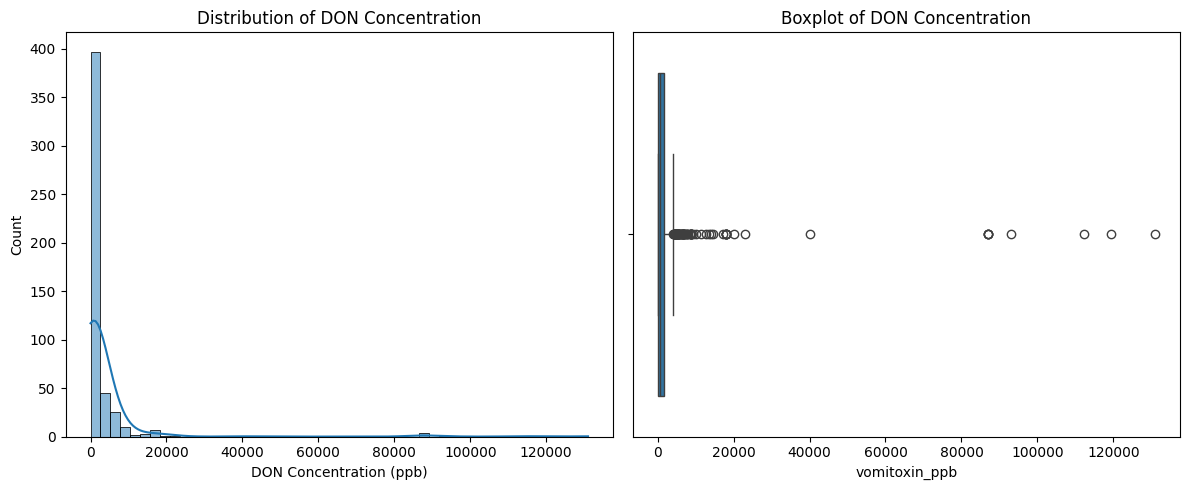

In [21]:
# 3. Plot histogram and boxplot of the target variable
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df[target_col], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of DON Concentration")
axes[0].set_xlabel("DON Concentration (ppb)")
sns.boxplot(x=df[target_col], ax=axes[1])
axes[1].set_title("Boxplot of DON Concentration")
plt.tight_layout()
plt.show()

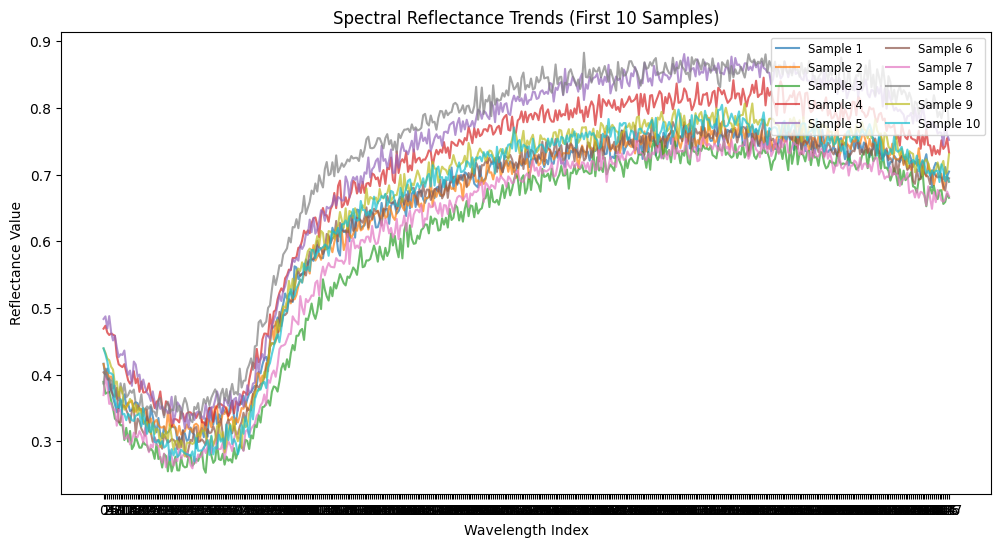

In [22]:
# 4. Visualize spectral reflectance trends (first 10 samples)
sample_spectra = df.iloc[:10, 1:-1].T  # Exclude 'hsi_id' and target column
plt.figure(figsize=(12, 6))
for i in range(sample_spectra.shape[1]):
    plt.plot(sample_spectra.index, sample_spectra.iloc[:, i], alpha=0.7, label=f'Sample {i+1}')
plt.title("Spectral Reflectance Trends (First 10 Samples)")
plt.xlabel("Wavelength Index")
plt.ylabel("Reflectance Value")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.show()

In [28]:
# 5. Anomaly Detection
# Z-score method
z_scores = np.abs(zscore(df[target_col]))
z_threshold = 3  # Common threshold
outliers_zscore = np.where(z_scores > z_threshold)[0]
print(f"Detected {len(outliers_zscore)} anomalies using Z-score method.")

Detected 8 anomalies using Z-score method.


In [29]:
# 5. Anomaly Detection
# IQR method
Q1 = df[target_col].quantile(0.25)
Q3 = df[target_col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = df[(df[target_col] < lower_bound) | (df[target_col] > upper_bound)].index
print(f"Detected {len(outliers_iqr)} anomalies using IQR method.")

Detected 80 anomalies using IQR method.


In [ ]:
# 5. Anomaly Detection
# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Normalize spectral data (Min-Max Scaling)
scaler = MinMaxScaler()
X = df.iloc[:, 1:-1]  # Exclude 'hsi_id' and target
X_scaled = scaler.fit_transform(X)
y = df[target_col].values

anomaly_preds = iso_forest.fit_predict(X_scaled)
df['anomaly'] = anomaly_preds
num_anomalies = (df['anomaly'] == -1).sum()
print(f"Detected {num_anomalies} anomalies using Isolation Forest.")

Detected 25 anomalies using Isolation Forest.


In [40]:
# 6. Remove Z-score detected anomalies
df_cleaned = df.drop(index=outliers_zscore).reset_index(drop=True)
print(f"Dataset size after removing anomalies: {df_cleaned.shape[0]} samples")

Dataset size after removing anomalies: 492 samples


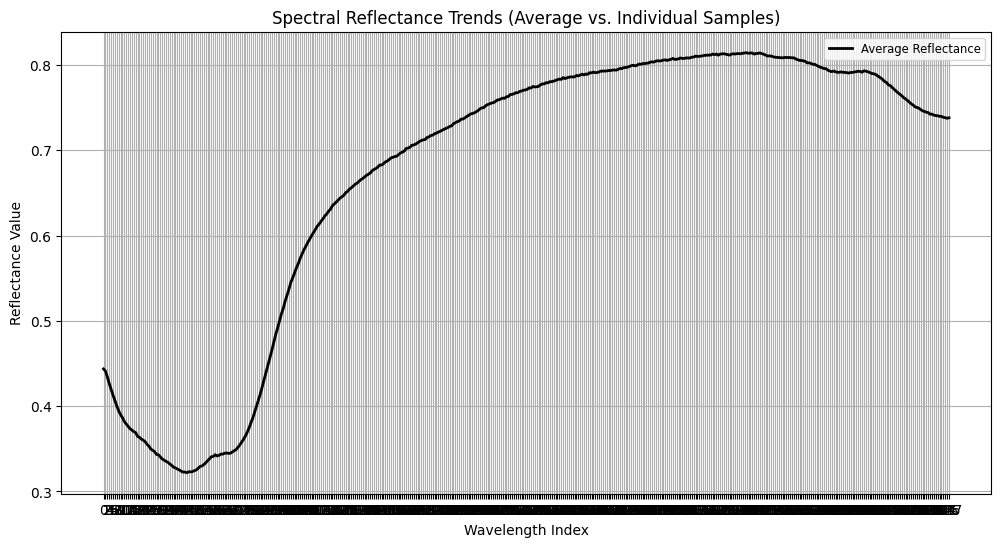

In [46]:
# 7. Average reflectance over wavelengths

# Compute the average reflectance over all samples for each wavelength
average_reflectance = df_cleaned.iloc[:, 1:-1].mean(axis=0)
average_reflectance.drop(average_reflectance.tail(1).index,
        inplace = True)

# Plot the average reflectance
plt.figure(figsize=(12, 6))
plt.plot(average_reflectance.index, average_reflectance.values, 
         color='black', linestyle='-', linewidth=2, label='Average Reflectance')

# Labels and title
plt.title("Spectral Reflectance Trends (Average vs. Individual Samples)")
plt.xlabel("Wavelength Index")
plt.ylabel("Reflectance Value")
plt.legend(loc="upper right", fontsize="small", ncol=2)
plt.grid(True)

# Show plot
plt.show()

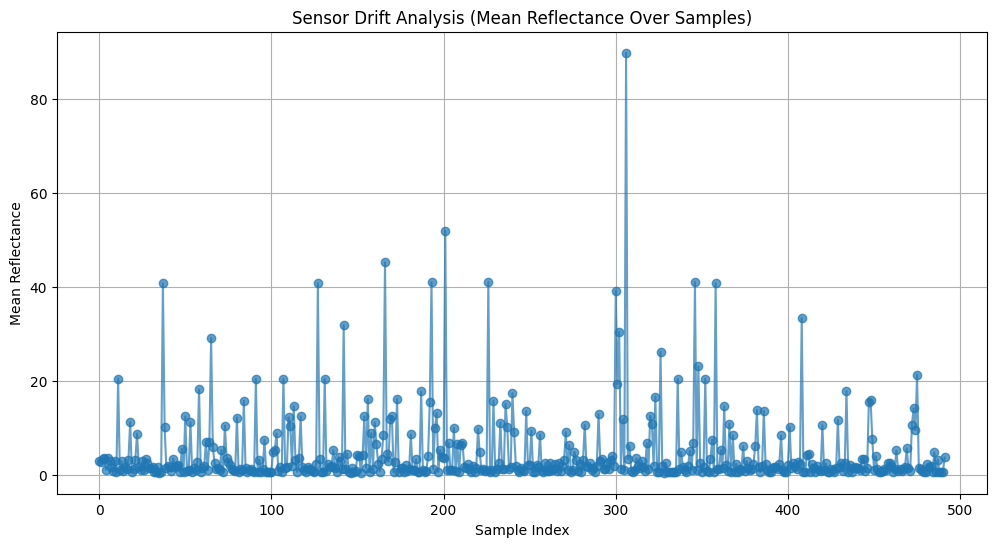

In [ ]:
# 8. Sensor Drift Detection

df_cleaned["mean_reflectance"] = df_cleaned.iloc[:, 1:-1].mean(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(df_cleaned["mean_reflectance"], marker='o', linestyle='-', alpha=0.7)
plt.title("Sensor Drift Analysis (Mean Reflectance Over Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Mean Reflectance")
plt.grid(True)
plt.show()

In [ ]:
# 8. Detect Sudden Jumps (Data Inconsistencies)

df_cleaned["reflectance_diff"] = df_cleaned["mean_reflectance"].diff().abs()
threshold = df_cleaned["reflectance_diff"].mean() + 3 * df_cleaned["reflectance_diff"].std()
inconsistent_samples = df_cleaned[df_cleaned["reflectance_diff"] > threshold]

In [52]:
# 8. Remove the inconsistent samples

# Remove inconsistent samples
df_filtered = df_cleaned[df_cleaned["reflectance_diff"] <= threshold].drop(columns=["reflectance_diff"])

print(f"Removed {len(inconsistent_samples)} inconsistent samples. New dataset size: {df_filtered.shape}")

# Optionally, instead of removing, we can apply interpolation to correct the anomalies:
df_interpolated = df_cleaned.copy()
df_interpolated.iloc[:, 1:-2] = df_interpolated.iloc[:, 1:-2].interpolate(method='linear', axis=0)

print("Applied interpolation to fix inconsistencies instead of removing them.")

Removed 16 inconsistent samples. New dataset size: (475, 452)
Applied interpolation to fix inconsistencies instead of removing them.


In [39]:
# . Normalize spectral data (Min-Max Scaling)
scaler = MinMaxScaler()
X = df.iloc[:, 1:-1]  # Exclude 'hsi_id' and target
X_scaled = scaler.fit_transform(X)
y = df[target_col].values

# . Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 400, Testing samples: 100
